In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore") 

import sys
sys.path.append('../')
from Agnes import Agnes
from utils import report, plot_graphs, accuracy
from DBscan import DBscan 

cmap = 'Spectral'

In [2]:
data = pd.read_csv('datset.csv') 
cat = ['OverTime', 'MaritalStatus', 'JobRole', 'Gender', 'EducationField', 'Department', 'BusinessTravel', 'Attrition']
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1)
for i in cat:
    data[i] = (data[i].astype('category').cat.codes).apply(np.int64)
X, y = data.drop(['Attrition'], axis=1), data['Attrition']

In [3]:
X, y = np.array(X), list(y)

data_x = data.drop(['Attrition'], axis=1)
X_standardized = np.array((data_x - data_x.mean()) / data_x.std())
X_normalized = np.array(((data_x - data_x.min()) / (data_x.max() - data_x.min())))

In [4]:
def grid_search(eps_list, min_samples_list, X, dist_matrix, similarity):
    results = pd.DataFrame(columns=['eps', 'min_samples', 'nb_clusters', 'noise', 'score'])
    for eps in tqdm(eps_list):
        for min_samples in min_samples_list:
            dbscan = DBscan(eps=eps, min_samples=min_samples, similarity=similarity) 
            clusters = dbscan.cluster(X, dist_matrix=dist_matrix) 
            results = results.append({'eps': eps,
                                    'min_samples': min_samples,
                                    'nb_clusters': len(np.unique(clusters)) - 1, 
                                    'noise': list(clusters).count(-2),
                                    'accuracy': accuracy(y, list(clusters)),
                                    'score': adjusted_rand_score(y, clusters)}, ignore_index=True)
    return results

# Hamming

## Grid Search

In [5]:
dist_matrix = np.load('..//Distance_matrices//Distances_Hamming.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(0.3, 1.0)

In [6]:
eps_list = np.arange(0, 1, 0.05) 
min_samples_list = range(1, 20) 
results_H = grid_search(eps_list, min_samples_list, X, dist_matrix, 'hamming')

100%|██████████| 20/20 [02:37<00:00,  7.86s/it]


In [7]:
results_H 

,eps,min_samples,nb_clusters,noise,score,accuracy
0,0.00,1.0,1469.0,0.0,0.0,0.00000
1,0.00,2.0,0.0,1470.0,0.0,0.00000
2,0.00,3.0,0.0,1470.0,0.0,0.00000
3,0.00,4.0,0.0,1470.0,0.0,0.00000
4,0.00,5.0,0.0,1470.0,0.0,0.00000
...,...,...,...,...,...,...
375,0.95,15.0,0.0,0.0,0.0,0.72232
376,0.95,16.0,0.0,0.0,0.0,0.72232
377,0.95,17.0,0.0,0.0,0.0,0.72232
378,0.95,18.0,0.0,0.0,0.0,0.72232


# Manhattan


## Grid Search

### Raw

In [8]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(105.0, 43646.0)

In [9]:
eps_list = range(100, 4000, 100)
min_samples_list = range(1, 20)
results_M = grid_search(eps_list, min_samples_list, X, dist_matrix, 'manhattan')

100%|██████████| 39/39 [05:24<00:00,  8.33s/it]


In [10]:
results_M 

,eps,min_samples,nb_clusters,noise,score,accuracy
0,100.0,1.0,1469.0,0.0,0.000000,0.000000
1,100.0,2.0,0.0,1470.0,0.000000,0.000000
2,100.0,3.0,0.0,1470.0,0.000000,0.000000
3,100.0,4.0,0.0,1470.0,0.000000,0.000000
4,100.0,5.0,0.0,1470.0,0.000000,0.000000
...,...,...,...,...,...,...
736,3900.0,15.0,7.0,87.0,-0.071476,0.555877
737,3900.0,16.0,6.0,117.0,-0.071368,0.551068
738,3900.0,17.0,7.0,121.0,-0.069548,0.560562
739,3900.0,18.0,5.0,136.0,-0.071254,0.555620


### Norm

In [11]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan_Norm.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(1.6987427806585245, 19.499781669310412)

In [12]:
eps_list = np.arange(1, 20, 0.5)
min_samples_list = range(1, 20)
results_N = grid_search(eps_list, min_samples_list, X_normalized, dist_matrix, 'manhattan')

100%|██████████| 38/38 [07:39<00:00, 12.09s/it]


In [13]:
results_N

,eps,min_samples,nb_clusters,noise,score,accuracy
0,1.0,1.0,1469.0,0.0,0.0,0.00000
1,1.0,2.0,0.0,1470.0,0.0,0.00000
2,1.0,3.0,0.0,1470.0,0.0,0.00000
3,1.0,4.0,0.0,1470.0,0.0,0.00000
4,1.0,5.0,0.0,1470.0,0.0,0.00000
...,...,...,...,...,...,...
717,19.5,15.0,0.0,0.0,0.0,0.72232
718,19.5,16.0,0.0,0.0,0.0,0.72232
719,19.5,17.0,0.0,0.0,0.0,0.72232
720,19.5,18.0,0.0,0.0,0.0,0.72232


### Std

In [14]:
dist_matrix = np.load('..//Distance_matrices//Distances_Manhattan_Std.npy') 
s = not_inf = ~np.isinf(dist_matrix) 
np.min(dist_matrix), np.max(dist_matrix[s]) 

(6.306789533389955, 70.92801526813942)

In [15]:
eps_list = np.arange(6, 70, 1) 
min_samples_list = range(1, 20)
results_S = grid_search(eps_list, min_samples_list, X_standardized, dist_matrix, 'manhattan')

100%|██████████| 64/64 [17:12<00:00, 16.14s/it]


In [16]:
results_S 

,eps,min_samples,nb_clusters,noise,score,accuracy
0,6.0,1.0,1469.0,0.0,0.0,0.00000
1,6.0,2.0,0.0,1470.0,0.0,0.00000
2,6.0,3.0,0.0,1470.0,0.0,0.00000
3,6.0,4.0,0.0,1470.0,0.0,0.00000
4,6.0,5.0,0.0,1470.0,0.0,0.00000
...,...,...,...,...,...,...
1211,69.0,15.0,0.0,0.0,0.0,0.72232
1212,69.0,16.0,0.0,0.0,0.0,0.72232
1213,69.0,17.0,0.0,0.0,0.0,0.72232
1214,69.0,18.0,0.0,0.0,0.0,0.72232


# Summary

In [17]:
results_H['score'].max(), results_M['score'].max(), results_N['score'].max(), results_S['score'].max() 

(0.11352883275633335,
 0.07528669866253121,
 0.018210153689908446,
 0.01886607520790144)

In [39]:
results_H['accuracy'].max(), results_M['accuracy'].max(), results_N['accuracy'].max(), results_S['accuracy'].max() 

(0.7223198594024605,
 0.6137440758293838,
 0.7223198594024605,
 0.7223198594024605)

In [18]:
print('Hamming-------------------')
print(results_H.loc[results_H['score'].idxmax()])
print('Mnahattan-----------------')
print(results_M.loc[results_M['score'].idxmax()]) 
print('Manhattan Norm-----------') 
print(results_N.loc[results_N['score'].idxmax()])
print('Manhattan Std------------') 
print(results_S.loc[results_N['score'].idxmax()])

Hamming-------------------
eps               0.500000
min_samples      19.000000
nb_clusters       2.000000
noise          1275.000000
score             0.113529
accuracy          0.054465
Name: 208, dtype: float64
Mnahattan-----------------
eps            1000.000000
min_samples       9.000000
nb_clusters      18.000000
noise          1212.000000
score             0.075287
accuracy          0.007427
Name: 179, dtype: float64
Manhattan Norm-----------
eps              4.500000
min_samples      1.000000
nb_clusters    556.000000
noise            0.000000
score            0.018210
accuracy         0.028976
Name: 133, dtype: float64
Manhattan Std------------
eps              13.000000
min_samples       1.000000
nb_clusters    1161.000000
noise             0.000000
score             0.000127
accuracy          0.000000
Name: 133, dtype: float64


In [20]:
print('Hamming-------------------')
print(results_H.loc[results_H['accuracy'].idxmax()])
print('Mnahattan-----------------')
print(results_M.loc[results_M['accuracy'].idxmax()]) 
print('Manhattan Norm-----------') 
print(results_N.loc[results_N['accuracy'].idxmax()])
print('Manhattan Std------------') 
print(results_S.loc[results_N['accuracy'].idxmax()])

Hamming-------------------
eps            0.95000
min_samples    1.00000
nb_clusters    0.00000
noise          0.00000
score          0.00000
accuracy       0.72232
Name: 361, dtype: float64
Mnahattan-----------------
eps            3900.000000
min_samples       1.000000
nb_clusters      22.000000
noise             0.000000
score            -0.051515
accuracy          0.613744
Name: 722, dtype: float64
Manhattan Norm-----------
eps            13.00000
min_samples     1.00000
nb_clusters     0.00000
noise           0.00000
score           0.00000
accuracy        0.72232
Name: 456, dtype: float64
Manhattan Std------------
eps            30.000000
min_samples     1.000000
nb_clusters     3.000000
noise           0.000000
score          -0.003269
accuracy        0.720141
Name: 456, dtype: float64


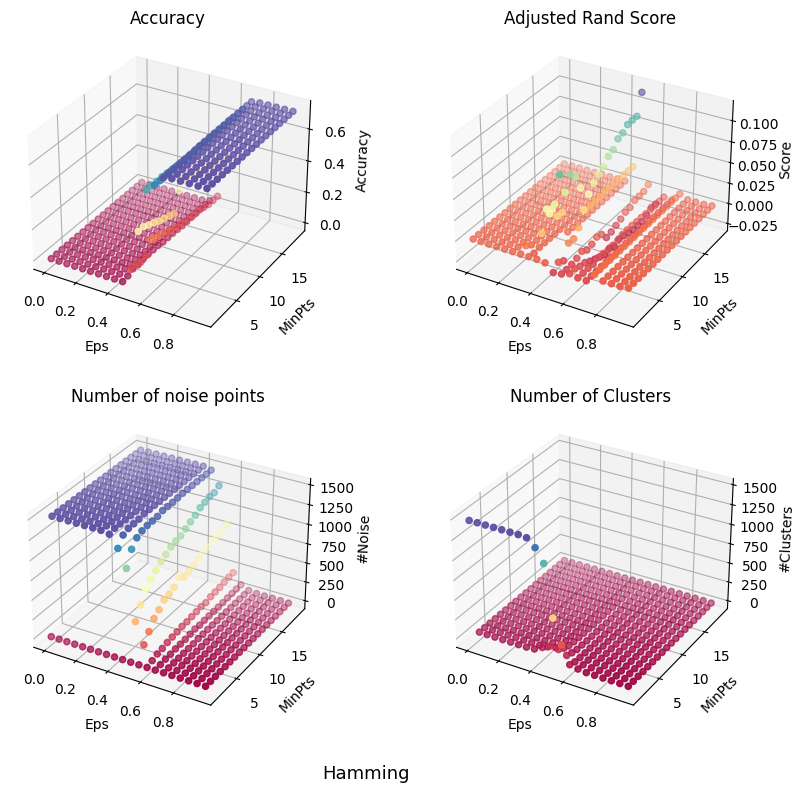

In [52]:
def plot_graphs(results, title, cmap='Spectral'):
    fig = plt.figure() 
    fig.set_size_inches(10, 9)

    X = results['eps']
    Y = results['min_samples']

    ax = fig.add_subplot(2, 2, 1, projection='3d')
    Z = results['accuracy']
    ax.scatter(X, Y, Z, c=Z, cmap=cmap)
    ax.set_xlabel('Eps')
    ax.set_ylabel('MinPts')
    ax.set_zlabel('Accuracy')
    ax.set_title('Accuracy')

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    Z = results['score']
    ax.scatter(X, Y, Z, c=Z, cmap=cmap)
    ax.set_xlabel('Eps')
    ax.set_ylabel('MinPts')
    ax.set_zlabel('Score')
    ax.set_title('Adjusted Rand Score')

    ax = fig.add_subplot(2, 2, 3, projection='3d')
    Z = results['noise']
    ax.scatter(X, Y, Z, c=Z, cmap=cmap)
    ax.set_xlabel('Eps')
    ax.set_ylabel('MinPts')
    ax.set_zlabel('#Noise')
    ax.set_title('Number of noise points')

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    Z = results['nb_clusters']
    ax.scatter(X, Y, Z, c=Z, cmap=cmap)
    ax.set_xlabel('Eps')
    ax.set_ylabel('MinPts')
    ax.set_zlabel('#Clusters')
    ax.set_title('Number of Clusters')

    fig.text(0.5, 0.05, title, ha='center', fontsize=13)
    plt.show()
plot_graphs(results_H, 'Hamming')

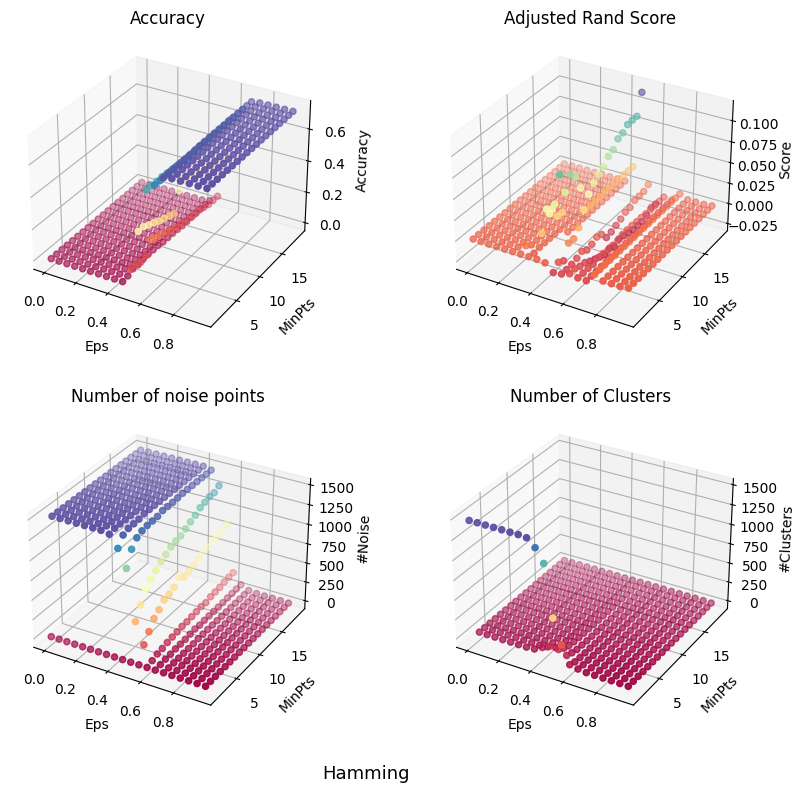

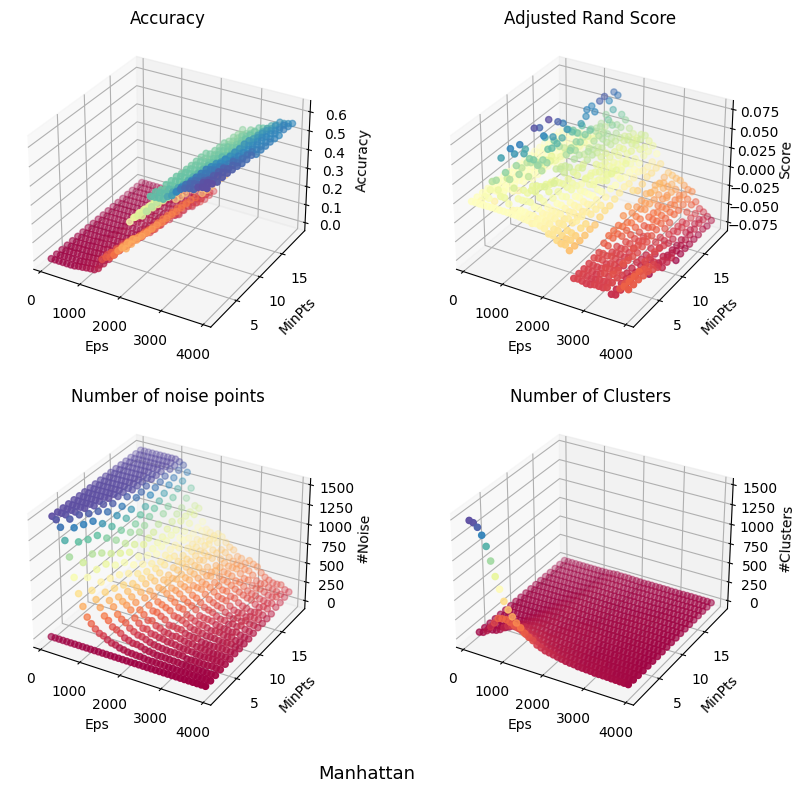

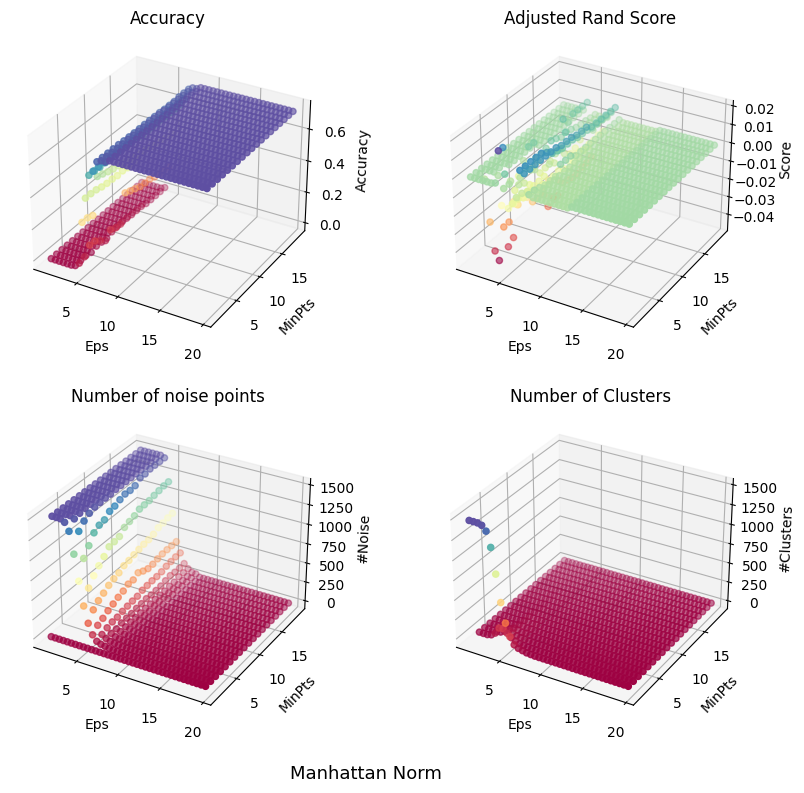

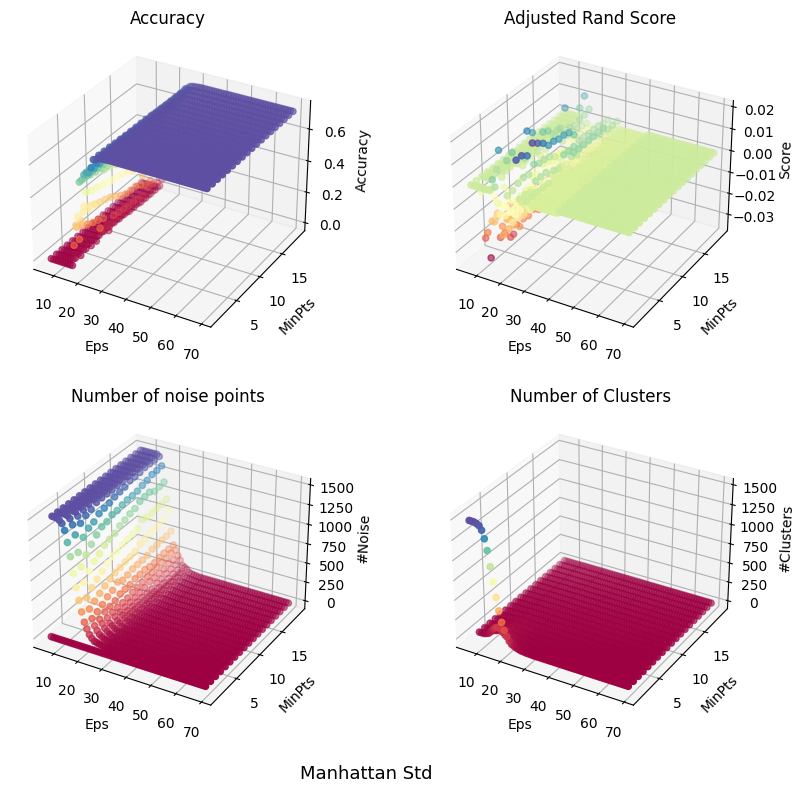

In [53]:
plot_graphs(results_H, 'Hamming')
plot_graphs(results_M, 'Manhattan')
plot_graphs(results_N, 'Manhattan Norm')
plot_graphs(results_S, 'Manhattan Std')  